In [2]:
from resources.workspace import *

/Users/brajard/Documents/recherche/collaboration/bigdata/DAPPER


DAPPER is a collection of tools to do benchmarking to investigate the impact of DA.

Benchmarking by "twin experiments" enables assessing the
 * impact of DA on models
 * performance of different DA methods
 
A twin experiment is structured as illustrated in the [previous section](T6 - Writing your own EnKF.ipynb). I.e. you
* specify a
	* dynamic model* 
	* observational model*
* use these to generate a synthetic
	* "truth"
	* and observations thereof*
* assess how different DA methods perform in estimating the truth, given the above starred (*) items.




The experiment of the previous section was sourced from reseach litterature (Sakov, Oliver, Bertino (2012). "An iterative EnKF for strongly nonlinear systems." Monthly Weather Review). It's transcribed in DAPPER, and may be found at: `[DAPPER-path]/mods/Lorenz63/sak12.py`
Have a look (through your Jupyter dashboard). Note
 * DAPPER uses the transpose orientation for ensemble matrices $\mathbf{E}$ compared to earlier in this tutorial (and EnKF litterature). This simplifies a lot of the code, but is something one must be aware of.
 * The `'jacob'` entries are there to allow using DA methods such as the (extended) Kalman filter.
 * Shortcut notation is sometimes allowed (such as `noise=0`), as this gets processed by object constructors.
 

### Setup

In [3]:
from mods.Lorenz63.sak12 import setup
setup.t.K = 1500  # shorten experiment

We can inspect the setup by printing it

In [4]:
setup

<TwinSetup>: Lorenz63/sak12.py
.  f: 
.     <Operator>
.     .  jacob: <function dfdx at 0x10beb06a8>
.     .  m: 3
.     .  model: <NamedFunc>(x0,t0,dt): rk4 integration of <function dxdt at 0x10beb0510> from mods.Lorenz63.core
.     .  noise: 
.     .     <GaussRV>
.     .     .  m: 3
.     .     .  mu: array([0., 0., 0.])
.     .     .  C: 0
.  h: 
.     <Operator>
.     .  jacob: <NamedFunc>(x,t): Id(3) matrix
.     .  m: 3
.     .  model: <NamedFunc>(): Id operator
.     .  noise: 
.     .     <GaussRV>
.     .     .  m: 3
.     .     .  mu: array([0., 0., 0.])
.     .     .  C: 
.     .     .     <CovMat>
.     .     .           m: 3
.     .     .        kind: 'diag'
.     .     .       trunc: 1.0
.     .     .          rk: 3
.     .     .        full:
.     .     .          [[2. 0. 0.]
.     .     .           [0. 2. 0.]
.     .     .           [0. 0. 2.]]
.     .     .        diag:
.     .     .           [2. 2. 2.]
.  t: 
.     <Chronology>
.           K: 1500
.        KObs: 59

### DA method

The other half of the preparation is to specify a DA method and its configuration.

In [5]:
defaults = {'store_u':True}
config = EnKF('PertObs',N=10,infl=1.04,**defaults)
config

EnKF(upd_a='PertObs', N=10, infl=1.04)

The methods are defined in `[DAPPER-path]/da_methods.py`.

### Run experiment

The rest of the experiment can be found in `[DAPPER-path]/example_1.py`. It is copy-pasted below. Run it.

In [6]:
# Simulate synthetic truth (xx) and noisy obs (yy)
xx,yy = simulate(setup)

# Assimilate yy (knowing the twin setup). Assess vis-a-vis xx.
stats = config.assimilate(setup,xx,yy)

# Average stats time series
avrgs = stats.average_in_time()

### Get results

The averages may be neatly displayed using `print_averages`, as follows

In [7]:
print_averages(config,avrgs,[],['rmse_a','rmv_a'])

     |  rmse_a ±      rmv_a ±
---  -  -----------  -----------
[0]  |  0.3731 0.08  0.5933 0.06


**Exc 7.2:**
There are also other statistics in `stats` (and their time-averages in `avrgs`).
 * (a). The subscript `_a` in the average statistics listed above indicate that the statistics were collected immediately following an **a**nalysis update. Instead of these, print the **f**orecast (`_f`) statistics (collected immediately before the analysis. Are they lower/higher? Why?

 * (b). Display all of the averages by executing `avrgs`.

In [8]:
avrgs

AlignedDict(**{
  logp_m_a: val_with_conf(val=-0.9, conf=0.4),
 logp_m_f: val_with_conf(val=-0.0, conf=0.5),
 logp_m_u: val_with_conf(val=-0.5, conf=0.5),
   skew_a: val_with_conf(val=-0.01, conf=0.05),
   skew_f: val_with_conf(val=0.03, conf=0.07),
   skew_u: val_with_conf(val=0.01, conf=0.06),
   kurt_a: val_with_conf(val=-1.0, conf=0.2),
   kurt_f: val_with_conf(val=-0.99, conf=0.09),
   kurt_u: val_with_conf(val=-1.04, conf=0.06),
    rmv_a: val_with_conf(val=0.59, conf=0.06),
    rmv_f: val_with_conf(val=1.2000000000000002, conf=0.4),
    rmv_u: val_with_conf(val=0.8, conf=0.1),
   rmse_a: val_with_conf(val=0.37, conf=0.08),
   rmse_f: val_with_conf(val=0.9, conf=0.30000000000000004),
   rmse_u: val_with_conf(val=0.6000000000000001, conf=0.2),
     trHK: val_with_conf(val=0.18, conf=0.03),
     infl: val_with_conf(val=nan, conf=nan)
})

Raw access to the time-series of statistics is through `stats.MYSTAT.X`, where `X` is either `a`, `f` or `u`. The `u` attribute refers to time series registered at every integration step (not just before/after analyses), but is only present if the DA method was configured with `store_u=True`).

In addition, DAPPER has some tools to plot some default diagnostics. For example:

<IPython.core.display.Javascript object>


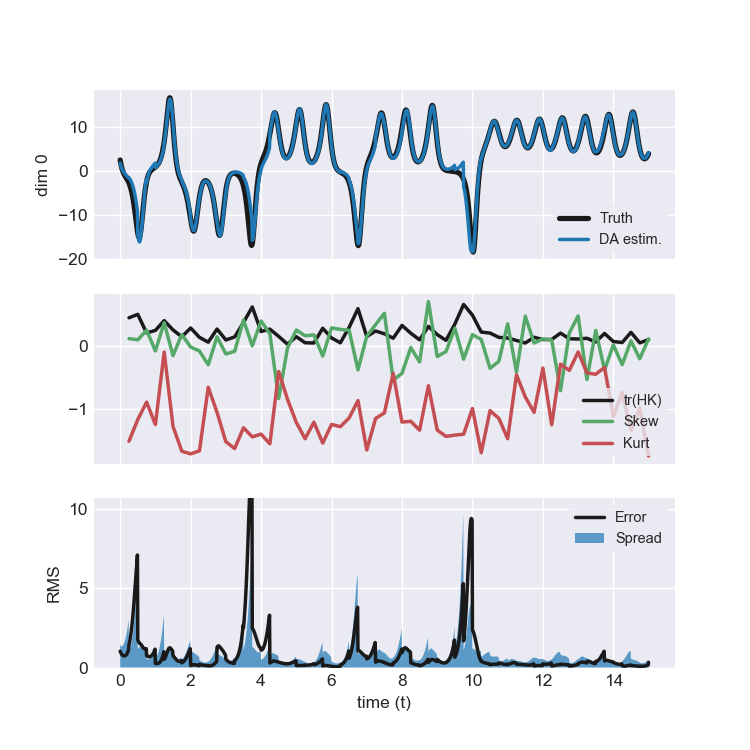

In [9]:
plot_time_series(stats)

If the experiment is sufficiently long, the `plot_XXX` functions will only plot up to a certain time range limit, estimated from the variability of the system. The limit can be adjusted using the input argument `T`.

**Exc 7.4:** Why are the diagnostics in the middle plot are sharper (more jagged) than the others ?

In [10]:
show_answer('jagged diagnostics')

<IPython.core.display.Javascript object>


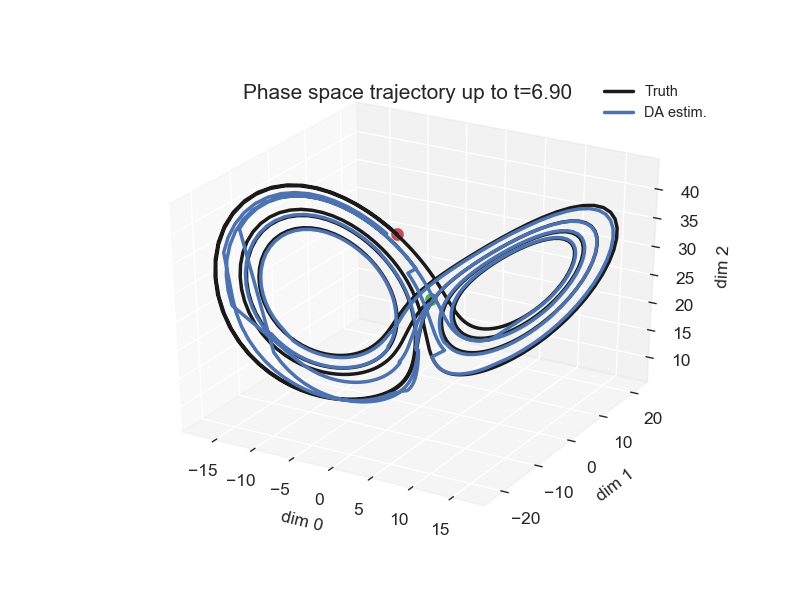

In [11]:
plot_3D_trajectory (stats)

<IPython.core.display.Javascript object>


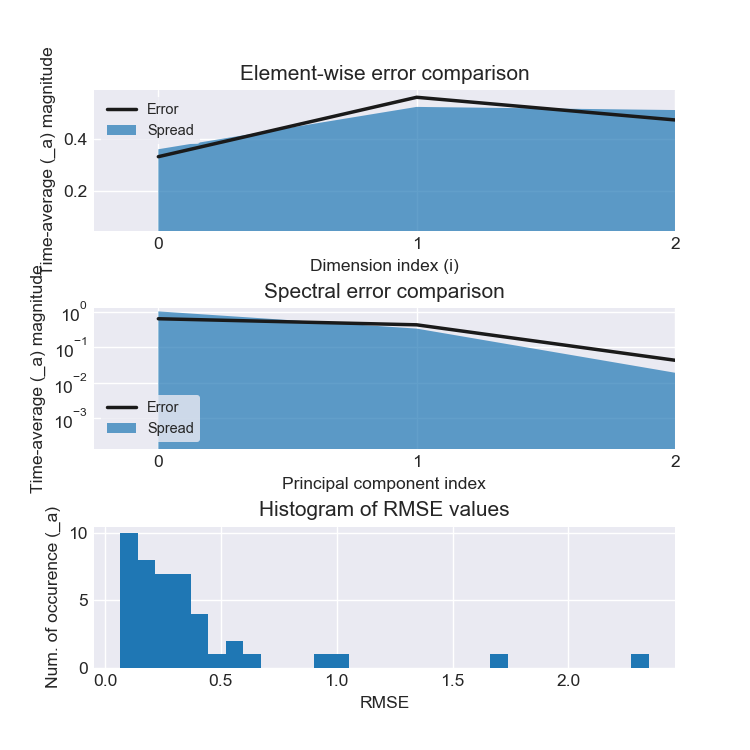

In [12]:
plot_err_components(stats)

**Exc 7.6*:** What is the probability law of RMSE values? What does this presuppose?

In [13]:
show_answer('RMSE hist')

<IPython.core.display.Javascript object>


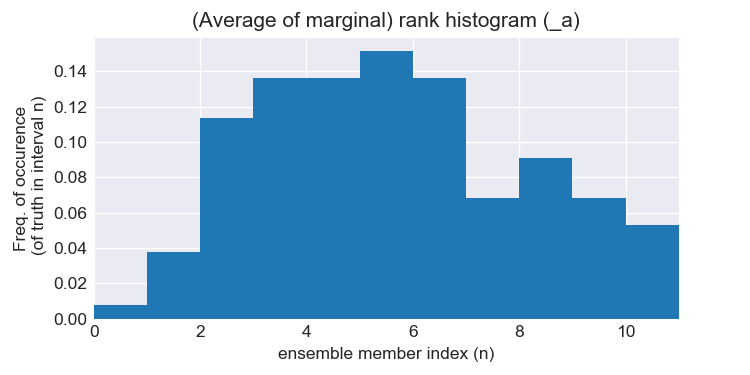

In [14]:
plot_rank_histogram(stats)

**Exc 7.8:** Does this indicate that the filter is to confident or too uncertain?

In [15]:
show_answer('Rank hist')

## Other DA methods

In [16]:
%matplotlib inline

Consider the "climatological mean":

In [17]:
mu = xx.mean(axis=0)
mu

array([ 2.8494654 ,  2.85786091, 23.71842713])

The truth `xx` is of course not available in reality, but a good estimate of its climatological mean should be possible to obtain. Even without doing any DA, we can say that this is an estimate of $\mathbf{x}_k$ (at any and all $k$).

**Exc 7.10:** Repeat the above twin experiment, but instead of the `EnKF`, use `Climatology` , which just uses `mu` as its estimate.

In [21]:
show_answer('Twin Climatology')
config = Var3D(**defaults)
avergs = config.assimilate(setup,xx,yy).average_in_time()
print_averages(config,avergs,[],['rmse_a','rmv_a'])



     |  rmse_a ±    rmv_a ±
---  -  ----------  -------
[0]  |    1.08 0.2  1.151 0


DA estimates states and parameters of dynamical systems.
At the very least, we should demand that a good DA method improves on `Climatology`.


**Exc 7.12:** Repeat the above twin experiment, but now use `Var3D`.

In [20]:
show_answer('Twin Var3D')

This manages to obtain an RMSE that is a good deal better.

This progression through improved methods can continue. Try it out with
 * `config = ExtKF(infl=90,**defaults)`
 * `config = EnKF_N(N=10,**defaults)`
 * `config = iEnKF('Sqrt',N=10,infl=1.02,rot=True,iMax=10,**defaults)`
 * `config = PartFilt(N=800,reg=0.9,NER=0.2,**defaults)`


Note, however, that they require tuning, or they might just not work at all. And it's not always possible to make a given method work on all problems.

Further DA method configurations are listed in `[DAPPER-path]/example_1.py`. Moreover, `example_2.py` shows how to run many one after another and compare them.

**Exc 7.14:** Adapt `[DAPPER-path]/example_2.py` to run multiple similar EnKF's one after another, but with different inflation factor values. Find the best-tuned performance (in terms of rmse accuracy).

**Exc 7.16:** Do a twin experiment with the setup from mods.Lorenz95.sak08. The same file also holds several DA method configurations to test with.
If you're running it locally, do this outside of jupyter, and use the setting `liveplotting=True` for the DA configuration.
See if you can understand the plots and diagnostics that pop up.

## Using DAPPER to benchmark new methods and models

Invent new DA methods. This is still an ongoing field of research. If you want to try it out with DAPPER, see the other methods in `da_methods.py` to learn about DAPPER syntax. The key points are to
 * use the `@DA_Config` wrapper.
 * define and return the inner `assimilator(stats,twin,xx,yy)` function with that signature.
 * make use of stats.assess (using 'a','f','u' to store the stats as '_a', '_f', or at all time steps)

You may also have some interesting models for testing. These should be wrapped usign `TwinSetup` if you wish to test the DA methods in DAPPER. Use the setup files under `[DAPPER-path]/mods` to see some examples.